In [505]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dctn, idctn
import imageio.v3 as iio
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
import math

# sources:
# T.871
# T.81
# https://www.youtube.com/watch?v=XhXWs7hStOw&list=PLGe7QU_YSVXczbFFlorJd9p8BNoi-HDv6&index=7
# jfif encoding for jpeg

In [506]:
Q_LUM = [
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 28, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99],
]

Q_CHROM = [
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
]

# default typical tables according to K.3.1 and K.3.2
HUFFMAN_DEFAULT_TABLES = {
    "dc_lum": {
        0: "00",
        1: "010",
        2: "011",
        3: "100",
        4: "101",
        5: "110",
        6: "1110",
        7: "11110",
        8: "111110",
        9: "1111110",
        10: "11111110",
        11: "111111110",
    },
    "dc_chrom": {
        0: "00",
        1: "01",
        2: "10",
        3: "110",
        4: "1110",
        5: "11110",
        6: "111110",
        7: "1111110",
        8: "11111110",
        9: "111111110",
        10: "1111111110",
        11: "11111111110",
    },
}
# TODO make encoder make custom huffman tables according to K.2

In [507]:
def zigzag_traverse(matrix):
    rows, cols = matrix.shape[:2]
    result = []
    row, col = 0, 0
    goingDown = False

    while not is_out_of_bounds(row, col, rows, cols):
        result.append(matrix[row][col])
        if goingDown:
            if col == 0:
                row += 1
                goingDown = False
            elif row == rows - 1:
                col += 1
                goingDown = False
            else:
                row += 1
                col -= 1
        else:
            if col == cols - 1:
                row += 1
                goingDown = True
            elif row == 0:
                col += 1
                goingDown = True
            else:
                row -= 1
                col += 1
    return np.array(result)


def is_out_of_bounds(row, col, rows, cols):
    return row < 0 or row >= rows or col < 0 or col >= cols


def pad(array, size):
    new_shape = (size, size)
    pad_width = [(0, max(0, new_shape[i] - array.shape[i])) for i in range(2)]
    padded_array = np.pad(array, pad_width=pad_width, mode="edge")
    result_array = np.concatenate(
        [padded_array] * (new_shape[0] // padded_array.shape[0]), axis=0
    )
    result_array = result_array[: new_shape[0], : new_shape[1]]
    return result_array


def rle(array):
    result = []
    zeros_count = 0
    for elem in array:
        elem = int(elem)
        if elem == 0:
            if zeros_count == 15:
                # ZRL zero run length
                # bin_rep = (f"{15:04b}{0:04b}", f"{0:08b}")
                result.append(((15, 0), 0))
                zeros_count = 0
            else:
                zeros_count += 1
        else:
            # symbol_1 = f"{zeros_count:04b}{elem.bit_length():04b}"
            # symbol_2 = f"{elem:08b}"
            result.append(((zeros_count, elem.bit_length()), elem))
            zeros_count = 0
    while result and result[-1] == ((15, 0), 0):
        result.pop()

    # EOB end of block
    result.append(((0, 0), 0))
    return result


def entropy_coding(YCbCr_image, block_size):
    layer_num = YCbCr_image.shape[2] if len(YCbCr_image.shape) == 3 else 1
    im_h, im_w = YCbCr_image.shape[:2]
    bl_h, bl_w = block_size, block_size
    blocks = [[], [], []]
    intermediary_img = np.zeros((im_h, im_w, layer_num), dtype=np.int32)
    for layer in range(layer_num):
        prev_dc = 0
        for row in range(0, im_h, bl_h):
            for col in range(0, im_w, bl_w):
                # block splitting
                block = YCbCr_image[row : row + bl_h, col : col + bl_w, layer]
                block = pad(block, bl_h)

                # dct
                block -= 128
                dct = dctn(block, norm="ortho")

                # quantization
                if layer == 0:
                    Q = Q_LUM
                else:
                    Q = Q_CHROM

                block = np.round(dct / Q).astype(np.int32)
                intermediary_img[row : row + bl_h, col : col + bl_w, layer] = block[
                    : im_h - row, : im_w - col
                ]

                # coefficient pattern sequential (single block at a time)
                zigzag = zigzag_traverse(block)
                dc_component, zigzag = zigzag[0], zigzag[1:]

                # DPCM
                dc_component -= prev_dc
                prev_dc = dc_component
                dc_component = (int(dc_component).bit_length(), dc_component)

                # rle ac components
                rle_ac = rle(zigzag)

                block = (dc_component, rle_ac)
                blocks[layer].append(block)

    return blocks, intermediary_img


def RGB_to_YCbCr(RGB_img, plot=False):
    R = RGB_img[:, :, 0]
    G = RGB_img[:, :, 1]
    B = RGB_img[:, :, 2]
    # A = RGB_img[:, :, 3]
    Y = np.clip(np.round(0.299 * R + 0.587 * G + 0.114 * B), 0, 255)
    Cb = np.clip(np.round((-0.299 * R - 0.587 * G + 0.886 * B) / 1.772 + 128), 0, 255)
    Cr = np.clip(np.round((0.701 * R - 0.587 * G - 0.114 * B) / 1.402 + 128), 0, 255)

    YCbCr_img = np.dstack((Y, Cb, Cr)).astype(np.uint8)
    if plot:
        fig = plt.figure(figsize=(16, 8), layout=None)
        gs = fig.add_gridspec(nrows=2, ncols=8)
        ax_left = fig.add_subplot(gs[0, 0:4])
        ax_right = fig.add_subplot(gs[0, 4:8])
        ax_left_mini1 = fig.add_subplot(gs[1, 0])
        ax_left_mini2 = fig.add_subplot(gs[1, 1])
        ax_left_mini3 = fig.add_subplot(gs[1, 2])
        # ax_left_mini4 = fig.add_subplot(gs[1, 3])

        ax_left.imshow(RGB_img)
        ax_left.set_title("RGB")
        ax_right.imshow(YCbCr_img)
        ax_right.set_title("YCbCr")

        ax_left_mini1.imshow(R, cmap="Reds")
        ax_left_mini1.set_title("Red")
        ax_left_mini2.imshow(G, cmap="Greens")
        ax_left_mini2.set_title("Green")
        ax_left_mini3.imshow(B, cmap="Blues")
        ax_left_mini3.set_title("Blue")
        # ax_left_mini4.imshow(A, cmap="Greys")
        # ax_left_mini4.set_title("Alpha")

        for ax in fig.axes:
            ax.axis("off")

        plt.show()

    return YCbCr_img


def YCbCr_to_RGB(YCbCr_img):
    Y = YCbCr_img[:, :, 0]
    Cb = YCbCr_img[:, :, 1]
    Cr = YCbCr_img[:, :, 2]

    R = np.clip(np.round(Y + 1.402 * (Cr - 128)), 0, 255)
    G = np.clip(
        np.round(Y - (0.114 * 1.772 * (Cb - 128) + 0.299 * 1.402 * (Cr - 128))), 0, 255
    )
    B = np.clip(np.round(Y + 1.772 * (Cb - 128)), 0, 255)

    RGB_img = np.dstack((R, G, B)).astype(np.uint8)
    return RGB_img


def huffman_encoding(blocks):
    pass

In [508]:
# 4:4:4 no downsampling
def compress(RGB_img, block_size):
    YCbCr = RGB_to_YCbCr(RGB_img)
    entropy_encoded, intermediary_img = entropy_coding(YCbCr, block_size)
    huffman_encoded = huffman_encoding(entropy_encoded)
    return entropy_encoded, intermediary_img

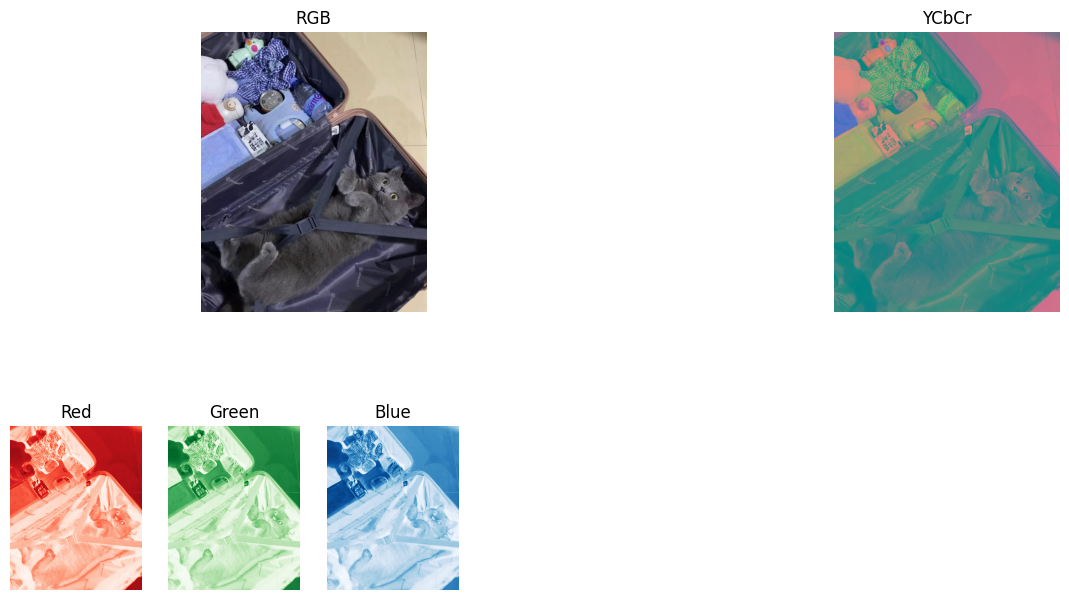

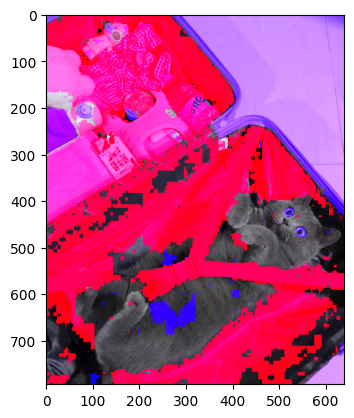

In [509]:
pisica = iio.imread("pisica.png")
YCbCr_pisica = RGB_to_YCbCr(pisica, plot=True)


test = YCbCr_to_RGB(YCbCr_pisica)
plt.imshow(test)
plt.show()

In [510]:
def decompress(compressed_img, block_size):
    layer_num = compressed_img.shape[2] if len(compressed_img.shape) == 3 else 1
    im_h, im_w = compressed_img.shape[:2]
    bl_h, bl_w = block_size, block_size
    intermediary_img = np.zeros((im_h, im_w, layer_num), dtype=np.int32)
    for layer in range(layer_num):
        for row in range(0, im_h, bl_h):
            for col in range(0, im_w, bl_w):
                # block splitting
                block = compressed_img[row : row + bl_h, col : col + bl_w, layer]
                block = pad(block, bl_h)

                if layer == 0:
                    Q = Q_LUM
                else:
                    Q = Q_CHROM

                # dequantization
                block = np.multiply(block, Q)

                # idctn
                block = idctn(block, norm="ortho").astype(np.int32)

                # dct
                block += 128
                block = np.clip(block, 0, 255)
                intermediary_img[row : row + bl_h, col : col + bl_w, layer] = block[
                    : im_h - row, : im_w - col
                ]
    return intermediary_img

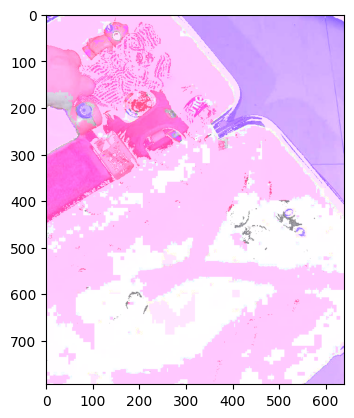

In [511]:
# layer -> block -> ((SIZE, value), (RUNLENGTH, SIZE, value))

encoded, compressed = compress(pisica, 8)

decompressed = decompress(compressed, 8)
decompressed = YCbCr_to_RGB(decompressed)
plt.imshow(decompressed)
plt.show()

In [512]:
org = np.array(
    [
        [52, 55, 61, 66, 70, 61, 64, 73],
        [63, 59, 55, 90, 109, 85, 69, 72],
        [62, 59, 68, 113, 144, 104, 66, 73],
        [63, 58, 71, 122, 154, 106, 70, 69],
        [67, 61, 68, 104, 126, 88, 68, 70],
        [79, 65, 60, 70, 77, 68, 58, 75],
        [85, 71, 64, 59, 55, 61, 65, 83],
        [87, 79, 69, 68, 65, 76, 78, 94],
    ]
)

cmprs = np.array(
    [
        [-26, -3, -6, 2, 2, -1, 0, 0],
        [0, -2, -4, 1, 1, 0, 0, 0],
        [-3, 1, 5, -1, -1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
    ],
    dtype=np.int32,
)

a = np.multiply(cmprs, Q_LUM)

a = idctn(a, norm="ortho").astype(np.int32) + 128
org - a

array([[-10,  -9,   2,  -5, -21, -20,  -3,  -6],
       [  3,   1,  -3,   8,   3,  -1,   6,  -2],
       [  3,   7,  10,  15,  18,  11,   7,   4],
       [  1,   5,   9,  12,  16,   6,  10,  -1],
       [ -2,  -1,   1,  -4,  -7, -11,   4,  -5],
       [  4,  -9, -11, -18, -30, -20, -11,  -6],
       [  7, -14,  -7,  -1, -16, -11,  -6,  -3],
       [  9, -12,   0,  28,  20,  16,   7,   7]])

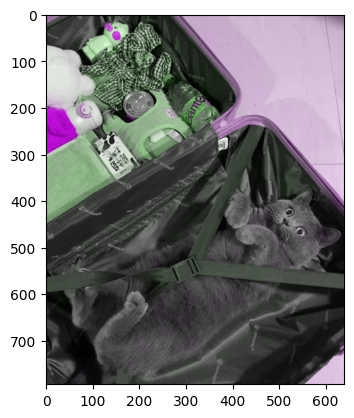

In [513]:
import cv2 as cv

b = YCbCr_pisica
b[:, :, 1], b[:, :, 2] = b[:, :, 2], b[:, :, 1]
b = cv.cvtColor(b, cv.COLOR_YCrCb2RGB)
plt.imshow(b)
plt.show()